In [21]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
from alpha_common_functions import lineplot

set_config(display="diagram")

In [22]:
df = pd.read_csv("data/vehicles_v3.csv")

# Drop Columns
#### 1. title_status has least variance with almost 95% of them have 'clean' status. We will not be considering the feature in model fitting.
#### 2. 71% of records are missing size, we will thus be skipping them too.
#### 3. region has 404 distinct values, this we will only consider state for the prediction 

In [23]:
df.drop(columns=['title_status','size','region'], inplace=True)

# Train - Test Split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['price'], axis=1), df['price'], test_size = 0.3, random_state = 42)

# Answer check
print(X_train.shape)
print(X_test.shape)

(211026, 11)
(90440, 11)


# Pre Processing

![](images/PreProcessing.svg)

## Transformers

### cylinders - OrdinalEncoder
1. Similarly 15.61% od NaN will be lables as "other" and will combine with	0.24% of "other"

In [25]:
categories_ = [[0.0, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0, 12.0]]
unknown_categories_ = len(categories_[0])
missing_categories_ = -1

cylinders_ordinal_encoder = OrdinalEncoder(encoded_missing_value=missing_categories_, categories=categories_, unknown_value=unknown_categories_, handle_unknown='use_encoded_value')                                           

### condition - OrdinalEncoder
1. 35.44% of records have no condition provided. we will be putting all of them to new label "other"

In [26]:
categories_=[["salvage", "fair", "good", "excellent","like new", "new"]]
unknown_categories_ = len(categories_[0])
missing_categories_ = -1

condition_ordinal_encoder = OrdinalEncoder(encoded_missing_value=missing_categories_, categories=categories_, unknown_value=unknown_categories_, handle_unknown='use_encoded_value')                                           

### transmission - (SimpleImputer -> OneHotEncoder)
1. Only 0.33% of all records are null. We do have additional category of "other" which is 18%+. Thus we will add 0.33%  of null as "other"
2. This will narrow down the transmossion to just 3 subcategories
### fuel - (SimpleImputer -> OneHotEncoder)
1. 0.07% of nissing values will be combined with 7.88% of "others"
2. We will have total 5 unique categories
### type - (SimpleImputer -> OneHotEncoder)
1. 15.21 of NaN will be combined with 5.37% of Other
2. In Total 12 categories will be remaining
### drive - (SimpleImputer -> OneHotEncoder)
1. 26.31% of NaN will be renamed as "Others
2. Total remaining categories will be 4
### paint_color - (SimpleImputer -> OneHotEncoder)
1. 28.19% of NaN will be renamed as "Others
2. Total remaining categories will be 13

In [27]:
simple_imputer = SimpleImputer(strategy='constant', fill_value='other')

<div class="alert alert-block alert-success">
    <font size=6 color='black'>
        Model 1
    </font>
    <br>
    <font size=5 color='black'>
    <u>PolynomialFeatures</u>
    </font>
    <p>
    Focus on this section will be on<br> 
    * SimpleImputer and then OneHotEncoder on 'transmission','fuel', 'type', 'drive', 'paint_color'<br> 
    * Plain OneHotEncoder on 'manufacturer','state'<br> 
    * OrdinalEncoder on 'condition' and 'cylinders'<br> 
    * StandardScaler and the PolynomialFeatures on 'year', 'odometer'<br> 
    </p>
</div>


<div class="alert alert-block alert-info">
    <font size=4>
        Determine the Polynomial Degree
    </font>
</div>

In [46]:
def get_MSE_for_degree_k_model(X_train, y_train, X_test, y_test, k):
    pipelined_model = Pipeline([
        ('transformer', make_column_transformer(
            (Pipeline([
                ('simple_imputer', simple_imputer),
                ('one_hot_encoder', OneHotEncoder())
            ]),['transmission','fuel', 'type', 'drive', 'paint_color']),
            (OneHotEncoder(),['manufacturer','state']),
            (condition_ordinal_encoder, ['condition']), 
            (cylinders_ordinal_encoder, ['cylinders']),
            (Pipeline([
                ('scalar', StandardScaler()),
                ('poly', PolynomialFeatures(include_bias = False, degree = k))
            ]) , ['year', 'odometer']),
            remainder='passthrough')), 
        ('regression', LinearRegression())
    ])
    pipelined_model.fit(X_train,y_train)
    predict_X_train = pipelined_model.predict(X_train)
    predict_X_test = pipelined_model.predict(X_test)
    return mean_squared_error(predict_X_train, y_train), mean_squared_error(predict_X_test , y_test)

In [47]:
mse_train = []
mse_test = []
for k in range(1, 5):
    _train, _test = get_MSE_for_degree_k_model(X_train, y_train, X_test, y_test, k)
    mse_train.append(_train)
    mse_test.append(_test)

Text(0.5, 1.0, 'Actual MSE vs Predicted MSE')

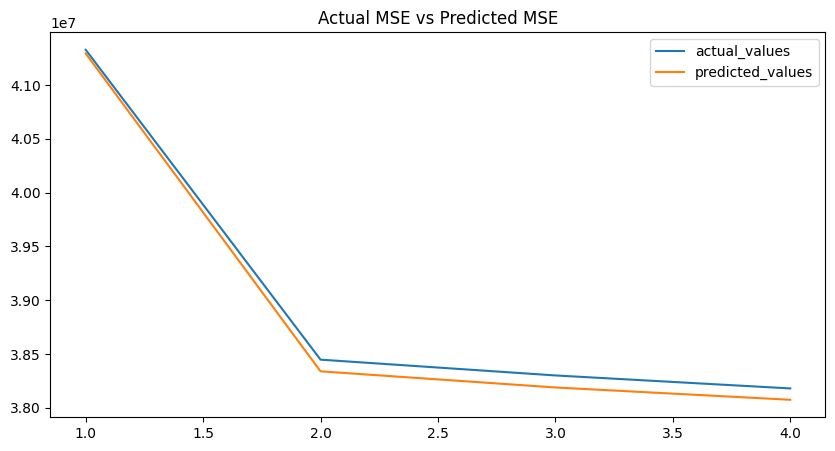

In [48]:
fix, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x = range(1,5), y = mse_train, label = 'actual_values');
sns.lineplot(x = range(1,5), y = mse_test, label = 'predicted_values');
plt.title("Actual MSE vs Predicted MSE")

<div class="alert alert-block alert-info">
    <font size=4>
        PolynomialFeatures's degree is "2"
    </font>
</div>

In [49]:
transformer = make_column_transformer(
    (Pipeline([
        ('simple_imputer', simple_imputer),
        ('one_hot_encoder', OneHotEncoder())
    ]),['transmission','fuel', 'type', 'drive', 'paint_color']),
    (OneHotEncoder(),['manufacturer','state']),
    (condition_ordinal_encoder, ['condition']), 
    (cylinders_ordinal_encoder, ['cylinders']),
    (Pipeline([
        ('scalar', StandardScaler()),
        ('poly', PolynomialFeatures(include_bias = False, degree = 2))
    ]) , ['year', 'odometer']),
    remainder='passthrough')

In [50]:
pipeline = Pipeline([
    ('transformer', make_column_transformer(
        (Pipeline([
            ('simple_imputer', simple_imputer),
            ('one_hot_encoder', OneHotEncoder())
        ]),['transmission','fuel', 'type', 'drive', 'paint_color']),
        (OneHotEncoder(),['manufacturer','state']),
        (condition_ordinal_encoder, ['condition']), 
        (cylinders_ordinal_encoder, ['cylinders']),
        (Pipeline([
            ('scalar', StandardScaler()),
            ('poly', PolynomialFeatures(include_bias = False, degree = 2))
        ]) , ['year', 'odometer']),
        remainder='passthrough')), 
        ('regression', LinearRegression())
    ])

In [51]:
pipeline.fit(X_train[['year', 'odometer','condition','cylinders', 'manufacturer','state', 'transmission','fuel', 'type','drive', 'paint_color']], y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value='other',
                                                                                 strategy='constant')),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder())]),
                                                  ['transmission', 'fuel',
                                                   'type', 'drive',
                                                   'paint_color']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['manufacturer', 'state']),
                                                 ('ordinal...
                                                  ['condition']),
                                                 ('ordinalencoder-2',
                                                  OrdinalEncoder(categories=[[0.0,
                                                                              3.0,
                                                                              4.0,
                                                                              5.0,
                                                                              6.0,
                                                                              8.0,
                                                                              10.0,
                                                                              12.0]],
                                                                 encoded_missing_value=-1,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=8),
                                                  ['cylinders']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('scalar',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['year', 'odometer'])])),
                ('regression', LinearRegression())])

In [52]:
y_train_predict = pipeline.predict(X_train[['year', 'odometer','condition','cylinders', 'manufacturer','state', 'transmission','fuel', 'type','drive', 'paint_color']])
y_test_predict = pipeline.predict(X_test[['year', 'odometer','condition','cylinders', 'manufacturer','state', 'transmission','fuel', 'type','drive', 'paint_color']])
#predict on train and test
train_mses=(mean_squared_error(y_train, y_train_predict))
test_mses=(mean_squared_error(y_test, y_test_predict))

In [53]:
print(train_mses)
print(test_mses)

38448522.10177266
38339991.10279321


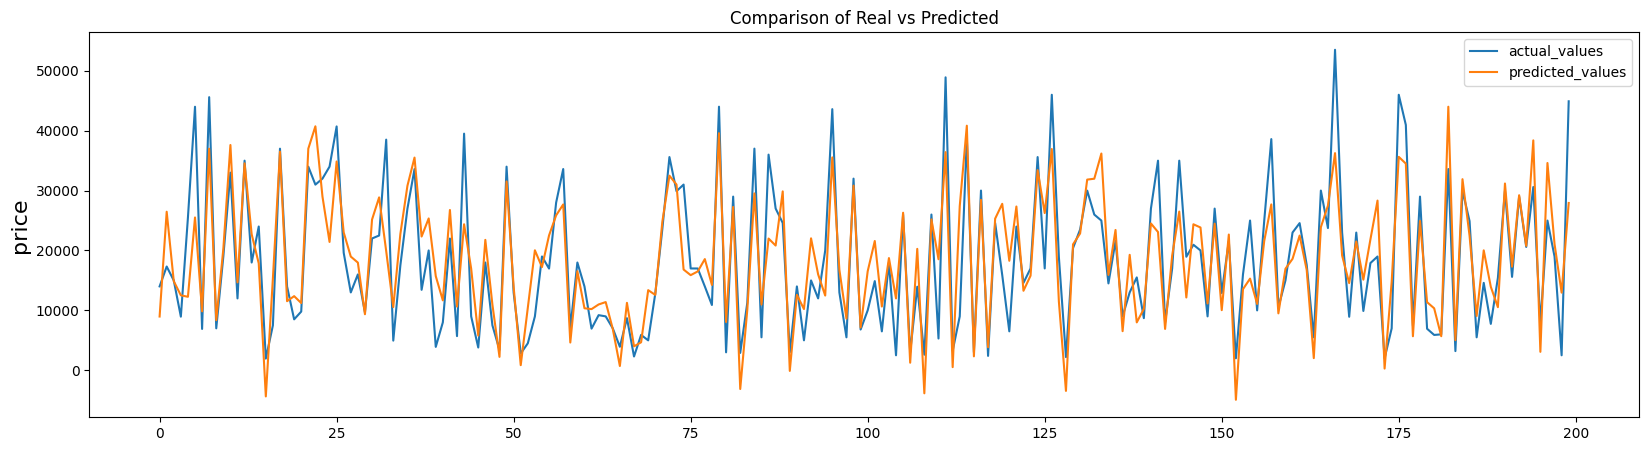

In [54]:
lineplot(y_test, y_test_predict, 200, "PolynomialFeatures_Degree_2")

In [55]:
coef_ = pipeline.named_steps['regression'].coef_

In [56]:
all_features_names = pipeline.named_steps['transformer'].get_feature_names_out()

In [57]:
coef = pd.DataFrame({"feature": all_features_names, "coeffecient": coef_})

In [58]:
coef

,feature,coeffecient
0,pipeline-1__transmission_automatic,-1123.684853
1,pipeline-1__transmission_manual,360.742902
2,pipeline-1__transmission_other,762.941948
3,pipeline-1__fuel_diesel,9579.829983
4,pipeline-1__fuel_electric,-5693.865085
...,...,...
132,pipeline-2__year,6713.361865
133,pipeline-2__odometer,-3950.292798
134,pipeline-2__year^2,1311.930193
135,pipeline-2__year odometer,242.931367


In [60]:
pipeline.named_steps['regression'].intercept_

15306.724537254777

In [61]:
pipeline.named_steps['regression'].n_features_in_

137